# Background
Getting the path, loading the train/valid and creating datablock

~Create a python enviroment version 3.11.8 is possible then install everything in requirements.txt~

In [2]:
# Set the path to where you have the dataset ex. "C:\Users\James\Desktop\bone freacture 451 project\bone_fracture_dataset_splitted"
path = ''
path

'C:/Users/bmocc/OneDrive/Documents/SCSU/Spring 2024/CSC 451/Data/bone_fracture_dataset_splitted'

In [3]:
# importing the data.yaml (should be in same folder where dataset is)

import yaml

with open(path+'/data.yaml', 'r') as f:
    data_structure = yaml.safe_load(f)
    print(data_structure)

{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 7, 'names': ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive'], 'roboflow': {'workspace': 'veda', 'project': 'bone-fracture-detection-daoon', 'version': 4, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/veda/bone-fracture-detection-daoon/dataset/4'}}


In [24]:
from fastai.vision.all import *
import yaml
import pandas as pd
import warnings

data_dir = Path(path)
trainValid_image_path = data_dir/'trainValid/images'
trainValid_label_path = data_dir/'trainValid/labels'

# The class names are directly taken from the YAML file
class_names = data_structure['names']

def get_label(file_path):
    # Construct the filename for the label file by removing the image extension and appending .txt
    label_file_name = '.'.join(str(file_path.name).split('.')[:-1]) + '.txt'
    label_file_path = trainValid_label_path/label_file_name

    # Attempt to open the corresponding label file
    with open(label_file_path, 'r') as label_file:

        #print(label_file_path)

        label_values = label_file.read().split(' ')
        label = label_values[0]  # Assuming the first item is the label index

        #print(label)

        if not label:
            return 'N'
        return class_names[int(label)]

# Setting up the FastAI DataBlock
bone_fractures = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.5, seed=42),
    get_y=get_label,
    item_tfms=Resize(256),
    batch_tfms=aug_transforms(size=256, min_scale=0.75)
)

# Load the data
dls = bone_fractures.dataloaders(trainValid_image_path, bs=64)

print(class_names)

['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']


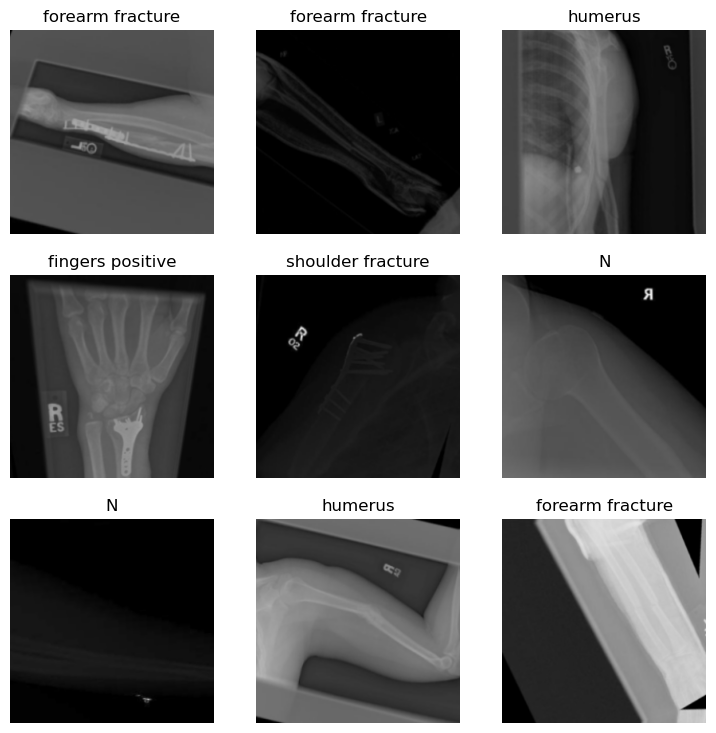

In [5]:
# Show an example
dls.show_batch()

# Counting the classes

In [40]:
from collections import Counter
import os

# Initialize a counter for all labels, including 'N'
label_counter = Counter()
labels = []

# Function to update the counter based on the label of each file
def update_label_counter(file_path):
    label_file_name = '.'.join(str(file_path.name).split('.')[:-1]) + '.txt'
    label_file_path = trainValid_label_path / label_file_name
    
    label = 'N'  # Default to 'N'
    with open(label_file_path, 'r') as label_file:
        label_values = label_file.read().strip().split(' ')
        if label_values[0].isdigit():
            label_index = int(label_values[0])
            if label_index < len(class_names):
                label = class_names[label_index]
                

    # Update the counter
    label_counter[label] += 1
    labels.append(label)

# Iterate over image files to update the counter
image_files = get_image_files(trainValid_image_path)
for image_file in image_files:
    update_label_counter(image_file)

# Display the count for each label, including 'N'
print(f"Label counts: {label_counter}")

Label counts: Counter({'N': 2002, 'fingers positive': 474, 'elbow positive': 334, 'shoulder fracture': 334, 'humerus': 330, 'forearm fracture': 320, 'wrist positive': 185})


In [41]:
#print(labels)

['elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'elbow positive', 'N', 'shoulder fracture', 'N', 'shoulder fracture', 'fingers positive', 'shoulder fracture', 'N', 'fingers positive', 'wrist positive', 'wrist positive', 'wrist positive', 'N', 'N', 'N', 'N', 'N', 'N', 'humerus', 'humerus', 'humerus', 'humerus', 'N', 'N', 'N', 'humerus', 'humerus', 'shoulder fracture', 'shoulder fracture', 'shoulder fracture', 'wrist positive', 'forearm fracture', 'forearm fracture', 'wrist positive', 'wrist positive', 'forearm fracture', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'elbow positive', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'fingers positive', 'fingers positive', 'fingers positive', 'elbow positive', 'N', 'elbow positive', 'elbow positive', 'forearm fracture', 'N', 'N', 'N', 'forearm fracture', 'forearm fracture', 'fingers positive', 'humerus', 'N', 'N', 'N', 'N', '

# Creating weighted classes so its "balanced"

In [43]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Assuming 'class_names' includes all your valid labels as earlier defined
#class_names = ['N', 'elbow positive', 'fingers positive', 'forearm fracture', 'humerus', 'shoulder fracture', 'wrist positive']

# Updated class frequencies to reflect your Counter data
#class_freqs = np.array([2002, 334, 474, 320, 330, 334, 185])
#print(class_freqs)
# Classes indices should range from 0 to number of classes - 1
#class_indices = np.arange(len(class_names))
#print(class_indices)

# Calculate class weights for all valid labels in 'y'
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

#class_weights = compute_class_weight('balanced', classes=class_indices, y=class_freqs)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Ensure the tensor is on the correct device (CPU or GPU)
class_weights_tensor = class_weights_tensor.to(dls.device)

# Define the loss function with class weights
loss_func = CrossEntropyLossFlat(weight=class_weights_tensor)

# Create a Learner with the custom loss function
#(For future use)
#learn = Learner(dls, model, loss_func=loss_func, metrics=accuracy)

[2002  334  474  320  330  334  185]
[0 1 2 3 4 5 6]


# testing to make sure it works (Basic Resnet34) just used for reference 

## Resnet 34 Test

epoch,train_loss,valid_loss,accuracy,time
0,2.533420,1.389909,0.522039,03:28


Better model found at epoch 0 with valid_loss value: 1.3899086713790894.


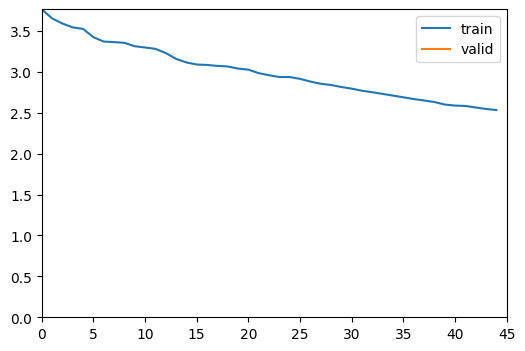

epoch,train_loss,valid_loss,accuracy,time
0,1.702201,1.173983,0.590909,04:27
1,1.480214,0.985097,0.679063,04:25
2,1.267411,0.820619,0.712121,04:24
3,1.061523,0.718485,0.756198,04:24
4,0.893115,0.700592,0.772727,04:24
5,0.761202,0.606572,0.790634,04:25
6,0.666370,0.563790,0.814050,04:38
7,0.581693,0.474505,0.829201,04:44
8,0.502331,0.525417,0.823691,04:31
9,0.428330,0.470096,0.844353,04:31


Better model found at epoch 0 with valid_loss value: 1.173982858657837.


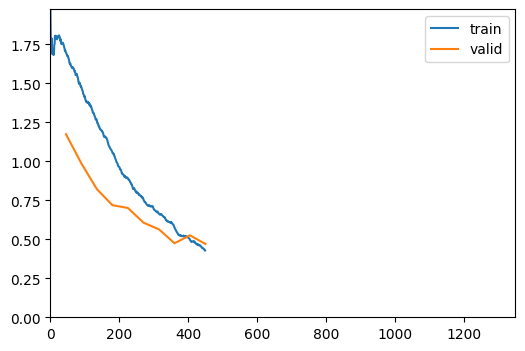

Better model found at epoch 1 with valid_loss value: 0.9850967526435852.
Better model found at epoch 2 with valid_loss value: 0.8206188678741455.
Better model found at epoch 3 with valid_loss value: 0.7184853553771973.
Better model found at epoch 4 with valid_loss value: 0.7005919218063354.
Better model found at epoch 5 with valid_loss value: 0.6065719127655029.
Better model found at epoch 6 with valid_loss value: 0.5637900233268738.
Better model found at epoch 7 with valid_loss value: 0.4745045304298401.
Better model found at epoch 9 with valid_loss value: 0.470096230506897.


KeyboardInterrupt: 

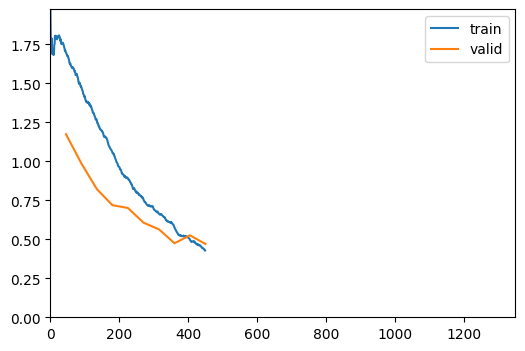

In [14]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(30, 0.001737800776027143, cbs=[ShowGraphCallback(), EarlyStoppingCallback(min_delta=0.001, patience=10), SaveModelCallback()])

## Displaying the results of model

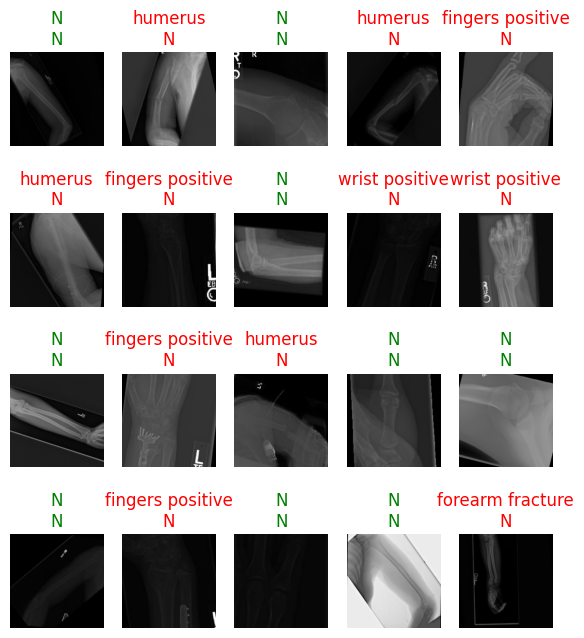

In [10]:
# visualize results (top row: true labels, bottom row: predicted labels)
learn.show_results(max_n = 20, figsize=(7,8))

# Make Branch and test various models under here...